# EDA - Time Series Impact on Predictions
- Should I use Time Series CV?
- What is the time period used?
- Is there a public source that aligns to this time series?

In [151]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pylab as plt
%matplotlib inline

In [29]:
train_id = pd.read_csv('../../inputs/train_identity.csv')
test_id = pd.read_csv('../../inputs/test_identity.csv')
train_tr = pd.read_csv('../../inputs/train_transaction.csv')
test_tr = pd.read_csv('../../inputs/test_transaction.csv')
ss = pd.read_csv('../../inputs/sample_submission.csv')

train_id = train_id.set_index('TransactionID')
train_tr = train_tr.set_index('TransactionID')
test_id = test_id.set_index('TransactionID')
test_tr = test_tr.set_index('TransactionID')

In [9]:
train_tr.shape

In [18]:
train_id.shape

(144233, 40)

In [20]:
train = train_tr.merge(train_id, left_index=True, right_index=True, how='outer')
test = test_tr.merge(test_id, left_index=True, right_index=True, how='outer')

In [24]:
train.shape

(590540, 433)

In [25]:
test.shape

(506691, 432)

In [27]:
# All data combined
data = pd.concat([train, test], sort=False)

In [33]:
data.to_parquet('../../data/raw_combined.parquet')

In [48]:
data['isTrain'] = True
data.loc[data['isFraud'].isna(), 'isTrain'] = False

# Create Day Feature

In [79]:
offset = 0.58
data['day'] = np.floor((data['TransactionDT'] / (3600 * 24))-1+offset)

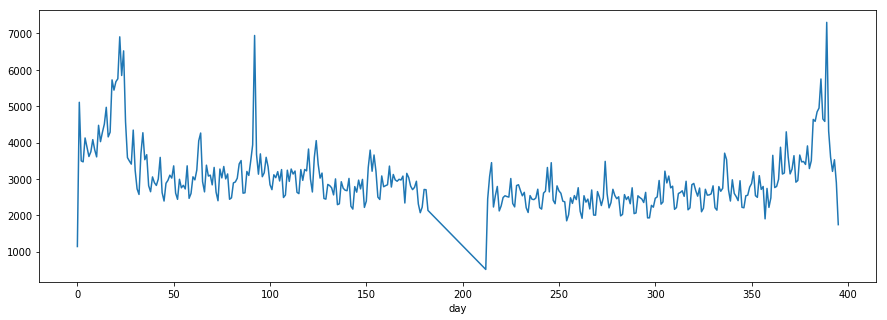

In [82]:
data.groupby('day').count()['TransactionDT'].plot(figsize=(15, 5))

# Look at Spikes. These are days in high spending....

In [88]:
data.groupby('day')['TransactionDT'].count().sort_values(ascending=False).head()

day
389.0    7305
92.0     6944
22.0     6907
24.0     6521
23.0     5844
Name: TransactionDT, dtype: int64

In [92]:
389 - 354

35

In [118]:
17 + 21

38

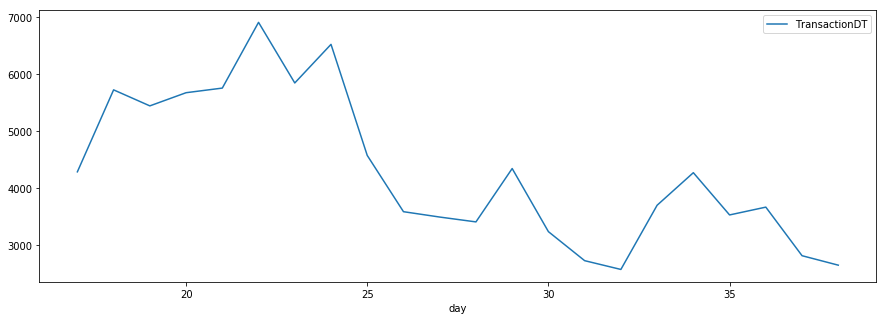

In [120]:
data.query('day >= 17 and day <= 38')[['day','TransactionDT']] \
    .groupby('day') \
    .count().plot(figsize=(15, 5))

In [121]:
381 + 21

402

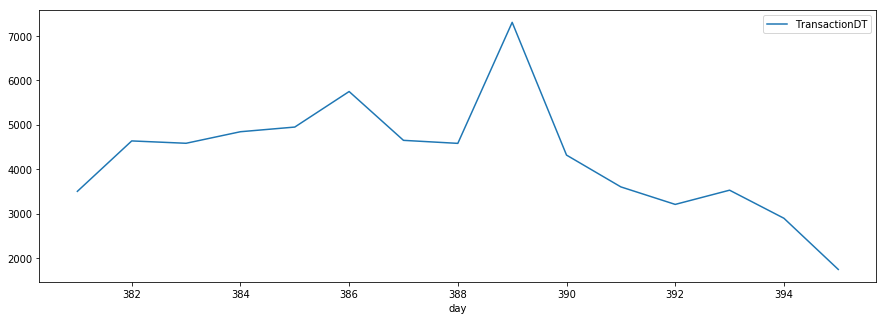

In [122]:
data.query('day >= 381 and day <= 402')[['day','TransactionDT']] \
    .groupby('day') \
    .count().plot(figsize=(15, 5))

In [124]:
382 - 18

364

In [128]:
data['day_year_lag'] = data['day'] - 364

In [132]:
data.loc[data['day_year_lag'] < 0, 'day_year_lag'] = np.nan

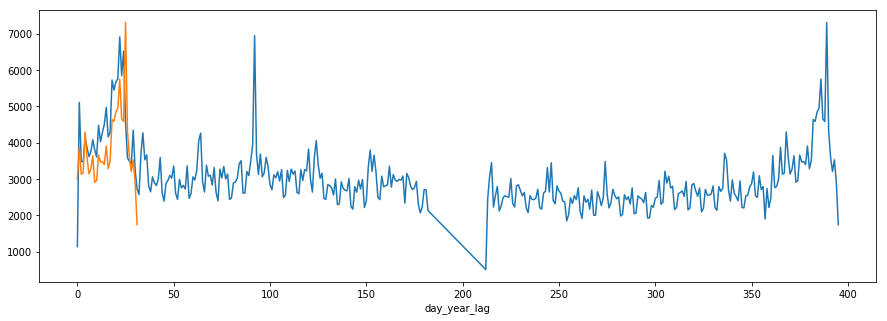

In [136]:
ax = data.groupby('day')['TransactionDT'].count().plot(figsize=(15, 5))
data.groupby('day_year_lag')['TransactionDT'].count().plot(figsize=(15, 5), ax=ax)

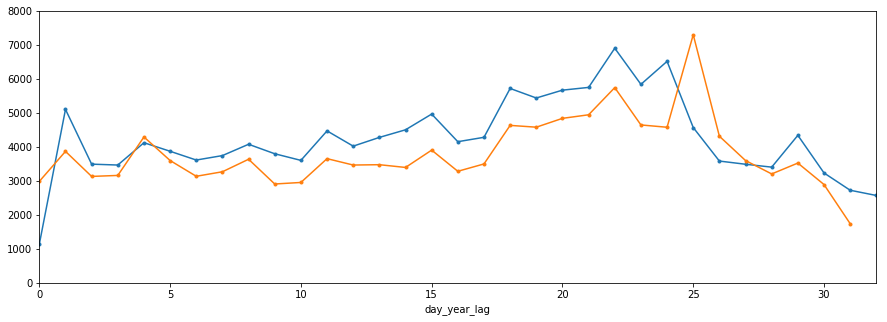

In [149]:
ax = data.groupby('day')['TransactionDT'].count().plot(figsize=(15, 5), xlim=(0, 32), ylim=(0, 8000), style='.-')
data.groupby('day_year_lag')['TransactionDT'].count().plot(figsize=(15, 5), ax=ax, style='.-')

# Expected High Spending Days
    2015	Fri	Nov 27	Black Friday	Observance
    2016	Fri	Nov 25	Black Friday	Observance
    2017	Fri	Nov 24	Black Friday	Observance
    2018	Fri	Nov 23	Black Friday	Observance
    2019	Fri	Nov 29	Black Friday	Observance

# Is day 1 black friday?


In [161]:
print(pd.to_datetime('Nov 25 2016') + dt.timedelta(days=25))
print(pd.to_datetime('Nov 24 2017') + dt.timedelta(days=25))
print(pd.to_datetime('Nov 23 2018') + dt.timedelta(days=25))

2016-12-20 00:00:00
2017-12-19 00:00:00
2018-12-18 00:00:00


In [280]:
print(pd.to_datetime('Nov 24 2017') + dt.timedelta(days=29))
print(pd.to_datetime('Nov 23 2018') + dt.timedelta(days=29))

2017-12-23 00:00:00
2018-12-22 00:00:00


In [91]:
pd.to_datetime('Nov 25 2016') - pd.to_datetime('Nov 27 2015')

Timedelta('364 days 00:00:00')

# Compare to Google Trends data for "Shopping

In [270]:
gt = pd.read_csv('../../data/google_trends_shopping.csv', header=1)#['shopping: (United States)'].plot(figsize=(15, 5))
gt.columns = gt.columns.str.replace(': \(United States\)', '')
gt['Week'] = pd.to_datetime(gt['Week'])
gt['shopping'] = (gt['shopping'] * 40) # Scale
gt['present'] = (gt['present'] * 50) # Scale

gt.head()

,Week,present,shopping
0,2014-08-31,1350,2720
1,2014-09-07,1600,2560
2,2014-09-14,1650,2640
3,2014-09-21,1550,2560
4,2014-09-28,1650,2600


In [282]:
data['date_guess'] = pd.to_datetime('1-NOV-2017') + data['day'].apply(dt.timedelta)

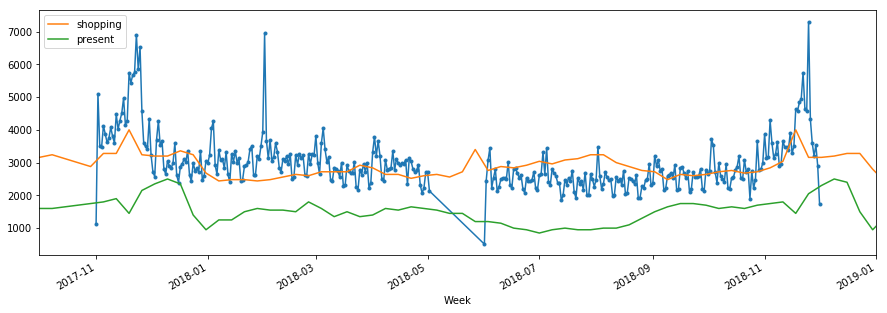

In [283]:
ax = data.groupby('date_guess')['TransactionDT'].count().plot(figsize=(15, 5), style='.-')
gt.set_index('Week')[['shopping','present']].plot(figsize=(15, 5), xlim=('1-Oct-2017','1-Jan-2019'), ax=ax)
plt.show()

In [286]:
data.groupby('date_guess')[['TransactionDT']].count().sort_values('TransactionDT', ascending=False).head()

,TransactionDT
date_guess,
2018-11-25,7305
2018-02-01,6944
2017-11-23,6907
2017-11-25,6521
2017-11-24,5844


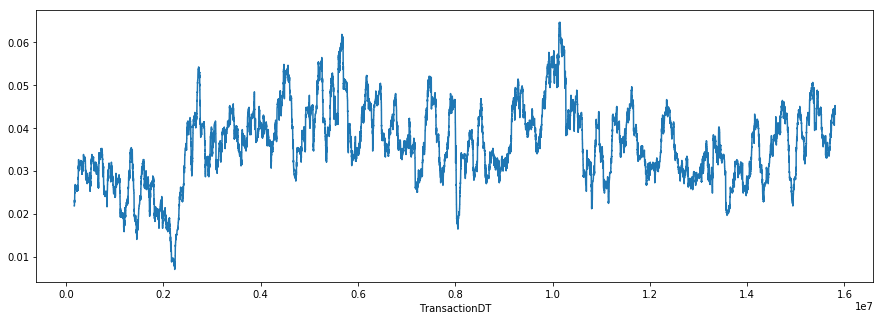

In [298]:
# fig, ax = plt.subplots()
ax = data.set_index('TransactionDT')['isFraud'].rolling(5000) \
        .mean() \
        .plot(figsize=(15, 5))

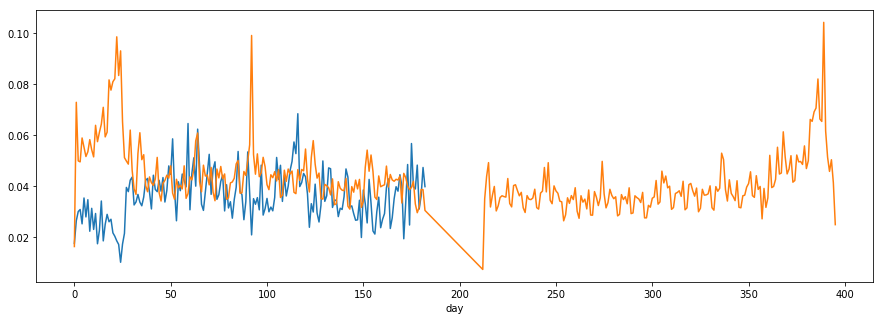

In [307]:
ax = data.groupby('day')['isFraud'] \
        .mean() \
        .plot(figsize=(15, 5))

(data.groupby('day')['TransactionDT'] \
        .count() / 70000) \
        .plot(figsize=(15, 5), ax=ax)

In [309]:
test.shape

(506691, 432)

In [310]:
506691 * 0.2

101338.20000000001

In [314]:
# https://www.kaggle.com/kevinbonnes/transactiondt-starting-at-2017-12-01
START_DATE = '2017-12-01'
startdate = dt.datetime.strptime(START_DATE, '%Y-%m-%d')
data['date'] = data['TransactionDT'].apply(lambda x: (startdate + dt.timedelta(seconds = x)))

In [316]:
data

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,...,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isTrain,day,day_year_lag,date_guess,date
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0.0,86400,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.0,NaN,2017-11-01,2017-12-02 00:00:00
2987001,0.0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.0,NaN,2017-11-01,2017-12-02 00:00:01
2987002,0.0,86469,59.000,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N